# Rotating Beam with a Swept Tip

In this example we analyze a rotating beam with a swept tip.  The parameters for this
example come from "Finite element solution of nonlinear intrinsic equations for curved
composite beams" by Hodges, Shang, and Cesnik.

![](../assets/rotating-drawing.svg)

In [1]:
using GXBeam, LinearAlgebra

sweep = 45 * pi/180
rpm = 0:25:750

# straight section of the beam
L_b1 = 31.5 ## inch
r_b1 = [2.5, 0, 0]
nelem_b1 = 13
lengths_b1, xp_b1, xm_b1, Cab_b1 = discretize_beam(L_b1, r_b1, nelem_b1)

# swept section of the beam
L_b2 = 6 ## inch
r_b2 = [34, 0, 0]
nelem_b2 = 3
cs, ss = cos(sweep), sin(sweep)
frame_b2 = [cs ss 0; -ss cs 0; 0 0 1]
lengths_b2, xp_b2, xm_b2, Cab_b2 = discretize_beam(L_b2, r_b2, nelem_b2;
    frame = frame_b2)

# combine elements and points into one array
nelem = nelem_b1 + nelem_b2
points = vcat(xp_b1, xp_b2[2:end])
start = 1:nelem_b1 + nelem_b2
stop = 2:nelem_b1 + nelem_b2 + 1
lengths = vcat(lengths_b1, lengths_b2)
midpoints = vcat(xm_b1, xm_b2)
Cab = vcat(Cab_b1, Cab_b2)

# cross section
w = 1 ## inch
h = 0.063 ## inch

# material properties
E = 1.06e7 ## lb/in^2
ν = 0.325
ρ = 2.51e-4 ## lb sec^2/in^4

# shear and torsion correction factors
ky = 1.2000001839588001
kz = 14.625127919304001
kt = 65.85255016982444

A = h*w
Iyy = w*h^3/12
Izz = w^3*h/12
J = Iyy + Izz

# apply corrections
Ay = A/ky
Az = A/kz
Jx = J/kt

G = E/(2*(1+ν))

compliance = fill(Diagonal([1/(E*A), 1/(G*Ay), 1/(G*Az), 1/(G*Jx), 1/(E*Iyy),
    1/(E*Izz)]), nelem)

mass = fill(Diagonal([ρ*A, ρ*A, ρ*A, ρ*J, ρ*Iyy, ρ*Izz]), nelem)

# create assembly
assembly = Assembly(points, start, stop;
    compliance = compliance,
    mass = mass,
    frames = Cab,
    lengths = lengths,
    midpoints = midpoints)

# create dictionary of prescribed conditions
prescribed_conditions = Dict(
    # root section is fixed
    1 => PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0, theta_z=0)
    )

nonlinear_states = Vector{AssemblyState{Float64}}(undef, length(rpm))
linear_states = Vector{AssemblyState{Float64}}(undef, length(rpm))
for i = 1:length(rpm)
    # global frame rotation
    w0 = [0, 0, rpm[i]*(2*pi)/60]

    # perform nonlinear steady state analysis
    system, converged = steady_state_analysis(assembly,
        angular_velocity = w0,
        prescribed_conditions = prescribed_conditions)

    nonlinear_states[i] = AssemblyState(system, assembly;
        prescribed_conditions = prescribed_conditions)

    # perform linear steady state analysis
    system, converged = steady_state_analysis(assembly,
        angular_velocity = w0,
        prescribed_conditions = prescribed_conditions,
        linear = true)

    linear_states[i] = AssemblyState(system, assembly;
        prescribed_conditions = prescribed_conditions)
end

nothing ##hide

To visualize the solutions we will plot the root moment and tip deflections against the
angular speed.

In [2]:
using Plots
pyplot()
nothing #hide

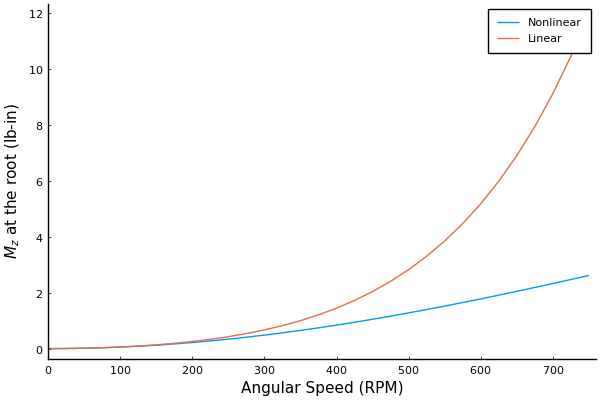

In [3]:
# root moment
plot(
    xlim = (0, 760),
    xticks = 0:100:750,
    xlabel = "Angular Speed (RPM)",
    yticks = 0.0:2:12,
    ylabel = "\$M_z\$ at the root (lb-in)",
    grid = false,
    overwrite_figure=false
    )
Mz_nl = [-nonlinear_states[i].points[1].M[3] for i = 1:length(rpm)]
Mz_l = [-linear_states[i].points[1].M[3] for i = 1:length(rpm)]
plot!(rpm, Mz_nl, label="Nonlinear")
plot!(rpm, Mz_l, label="Linear")

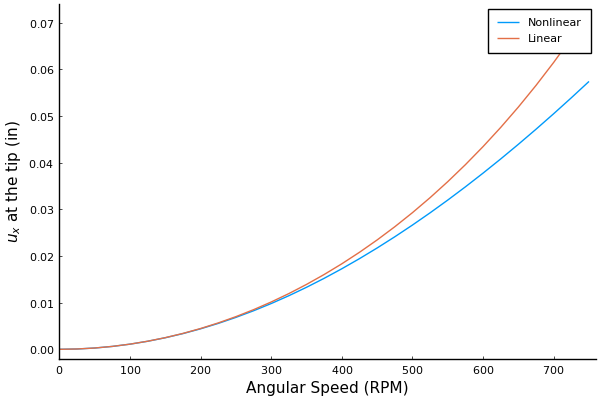

In [4]:
# x tip deflection
plot(
    xlim = (0, 760),
    xticks = 0:100:750,
    xlabel = "Angular Speed (RPM)",
    ylim = (-0.002, 0.074),
    yticks = 0.0:0.01:0.07,
    ylabel = "\$u_x\$ at the tip (in)",
    grid = false,
    overwrite_figure=false
    )
ux_nl = [nonlinear_states[i].points[end].u[1] for i = 1:length(rpm)]
ux_l = [linear_states[i].points[end].u[1] for i = 1:length(rpm)]
plot!(rpm, ux_nl, label="Nonlinear")
plot!(rpm, ux_l, label="Linear")

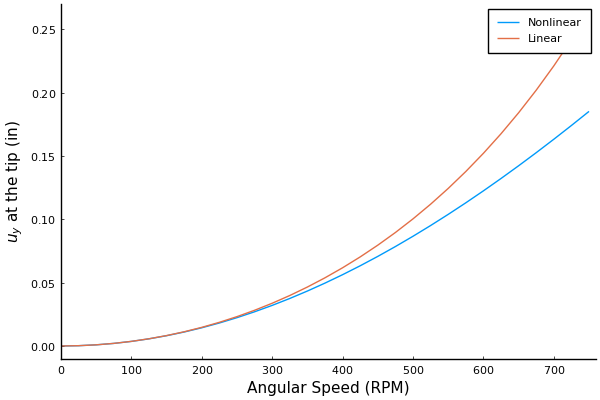

In [5]:
# y tip deflection
plot(
    xlim = (0, 760),
    xticks = 0:100:750,
    xlabel = "Angular Speed (RPM)",
    ylim = (-0.01, 0.27),
    yticks = 0.0:0.05:0.25,
    ylabel = "\$u_y\$ at the tip (in)",
    grid = false,
    overwrite_figure=false
    )
uy_nl = [nonlinear_states[i].points[end].u[2] for i = 1:length(rpm)]
uy_l = [linear_states[i].points[end].u[2] for i = 1:length(rpm)]
plot!(rpm, uy_nl, label="Nonlinear")
plot!(rpm, uy_l, label="Linear")

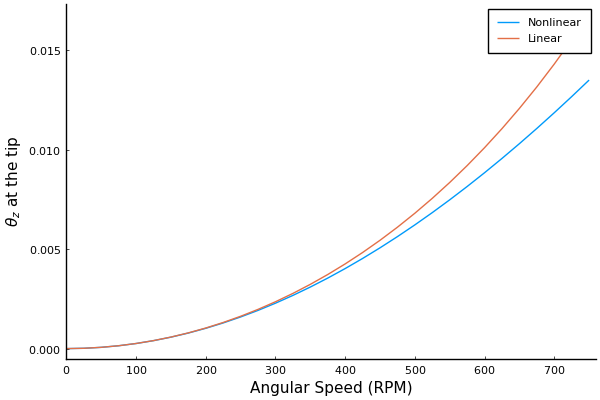

In [6]:
# rotation of the tip
plot(
    xlim = (0, 760),
    xticks = 0:100:750,
    xlabel = "Angular Speed (RPM)",
    ylabel = "\$θ_z\$ at the tip",
    grid = false,
    overwrite_figure=false
    )
theta_z_nl = [4*atan(nonlinear_states[i].points[end].theta[3]/4)
    for i = 1:length(rpm)]
theta_z_l = [4*atan(linear_states[i].points[end].theta[3]/4)
    for i = 1:length(rpm)]

plot!(rpm, theta_z_nl, label="Nonlinear")
plot!(rpm, theta_z_l, label="Linear")

We will now compute the eigenvalues of this system for a range of sweep angles and and
angular speeds.

In [7]:
sweep = (0:2.5:45) * pi/180
rpm = [0, 500, 750]
nev = 30

λ = Matrix{Vector{ComplexF64}}(undef, length(sweep), length(rpm))
U = Matrix{Matrix{ComplexF64}}(undef, length(sweep), length(rpm))
MV = Matrix{Matrix{ComplexF64}}(undef, length(sweep), length(rpm))
state = Matrix{AssemblyState{Float64}}(undef, length(sweep), length(rpm))
eigenstates = Matrix{Vector{AssemblyState{ComplexF64}}}(undef,
    length(sweep), length(rpm))
for i = 1:length(sweep)

    local L_b1, r_b1, nelem_b1, lengths_b1
    local xp_b1, xm_b1, Cab_b1
    local cs, ss
    local L_b2, r_b2, nelem_b2, frame_b2, lengths_b2
    local xp_b2, xm_b2, Cab_b2
    local nelem, points, start, stop
    local lengths, midpoints, Cab, compliance, mass, assembly

    # straight section of the beam
    L_b1 = 31.5 # inch
    r_b1 = [2.5, 0, 0]
    nelem_b1 = 20
    lengths_b1, xp_b1, xm_b1, Cab_b1 = discretize_beam(L_b1, r_b1, nelem_b1)

    # swept section of the beam
    L_b2 = 6 # inch
    r_b2 = [34, 0, 0]
    nelem_b2 = 20
    cs, ss = cos(sweep[i]), sin(sweep[i])
    frame_b2 = [cs ss 0; -ss cs 0; 0 0 1]
    lengths_b2, xp_b2, xm_b2, Cab_b2 = discretize_beam(L_b2, r_b2, nelem_b2;
        frame = frame_b2)

    # combine elements and points into one array
    nelem = nelem_b1 + nelem_b2
    points = vcat(xp_b1, xp_b2[2:end])
    start = 1:nelem_b1 + nelem_b2
    stop = 2:nelem_b1 + nelem_b2 + 1
    lengths = vcat(lengths_b1, lengths_b2)
    midpoints = vcat(xm_b1, xm_b2)
    Cab = vcat(Cab_b1, Cab_b2)

    compliance = fill(Diagonal([1/(E*A), 1/(G*Ay), 1/(G*Az), 1/(G*Jx),
        1/(E*Iyy), 1/(E*Izz)]), nelem)

    mass = fill(Diagonal([ρ*A, ρ*A, ρ*A, ρ*J, ρ*Iyy, ρ*Izz]), nelem)

    # create assembly
    assembly = Assembly(points, start, stop;
        compliance = compliance,
        mass = mass,
        frames = Cab,
        lengths = lengths,
        midpoints = midpoints)

    # create system
    system = System(assembly, false)

    for j = 1:length(rpm)
        # global frame rotation
        w0 = [0, 0, rpm[j]*(2*pi)/60]

        # eigenvalues and (right) eigenvectors
        system, λ[i,j], V, converged = eigenvalue_analysis!(system, assembly;
            angular_velocity = w0,
            prescribed_conditions = prescribed_conditions,
            nev = nev)

        # corresponding left eigenvectors
        U[i,j] = left_eigenvectors(system, λ[i,j], V)

        # post-multiply mass matrix with right eigenvector matrix
        # (we use this later for correlating eigenvalues)
        MV[i,j] = system.M * V

        # process state and eigenstates
        state[i,j] = AssemblyState(system, assembly;
            prescribed_conditions = prescribed_conditions)
        eigenstates[i,j] = [AssemblyState(system, assembly, V[:,k];
            prescribed_conditions = prescribed_conditions) for k = 1:nev]
    end
end

nothing #hide

We can correlate each eigenmode by taking advantage of the fact that left and right
eigenvectors satisfy the following relationships:

$$
\begin{aligned}
u^H M v &= 1 &\text{if \(u\) and \(v\) correspond to the same eigenmode} \\
u^H M v &= 0 &\text{if \(u\) and \(v\) correspond to different eigenmodes}
\end{aligned}
$$

In [8]:
# set previous left eigenvector matrix
U_p = copy(U[1,1])

for j = 1:length(rpm)
    for i = 1:length(sweep)
        # construct correlation matrix
        C = U_p*MV[i,j]

        # correlate eigenmodes
        perm, corruption = correlate_eigenmodes(C)

        # re-arrange eigenvalues and eigenvectors
        λ[i,j] = λ[i,j][perm]
        U[i,j] = U[i,j][perm,:]
        MV[i,j] = MV[i,j][:,perm]
        eigenstates[i,j] = eigenstates[i,j][perm]

        # update previous eigenvector matrix
        U_p .= U[i,j]
    end
    # update previous eigenvector matrix
    U_p .= U[1,j]
end

frequency = [[imag(λ[i,j][k])/(2*pi) for i = 1:length(sweep), j=1:length(rpm)]
    for k = 1:2:nev]

nothing #hide

In this case these eigenmode correlations work, but remember that large changes in the
underlying parameters (or just drastic changes in the eigenvectors themselves due to a
small perturbation) can cause these automatic eigenmode correlations to fail.

We'll now plot the frequency of the different eigenmodes against those found by Epps and
Chandra in "The Natural Frequencies of Rotating Composite Beams With Tip Sweep".

In [9]:
names = ["First Bending Mode", "Second Bending Mode", "Third Bending Mode"]
indices = [1, 2, 4]

experiment_rpm = [0, 500, 750]
experiment_sweep = [0, 15, 30, 45]
experiment_frequencies = [
    [1.4 1.8 1.7 1.6;
     10.2 10.1 10.2 10.2;
     14.8 14.4 14.9 14.7],
    [10.3 10.2 10.4 10.4;
     25.2 25.2 23.7 21.6;
     36.1 34.8 30.7 26.1],
    [27.7 27.2 26.6 24.8;
     47.0 44.4 39.3 35.1;
     62.9 55.9 48.6 44.8]
]
nothing #hide

┌ Warning: Keyword argument letter not supported with Plots.PyPlotBackend().  Choose from: annotations, arrow, aspect_ratio, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_edges, bar_position, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_tickfontcolor, colorbar_tickfontfamily, colorbar_tickfonthalign, colorbar_tickfontrotation, colorbar_tickfontsize, colorbar_tickfontvalign, colorbar_ticks, colorbar_title, connections, contour_labels, contours, discrete_values, dpi, fill_z, fillalpha, fillcolor, fillrange, flip, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_guide, foreground_color_subplot, foreground_color_text, foreground_color_title, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guide_position, guidefontcolor, guidefontfamily, guidefontsize, html_output_format, inset_subplots, label, 

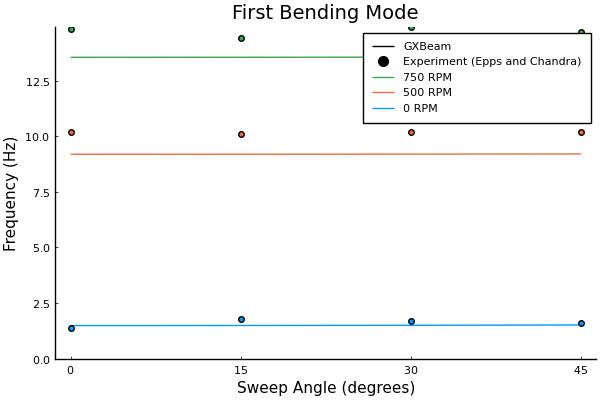

In [10]:
ph = Vector{Any}(undef, 3)

for k = 1:3
    ph[k] = plot(
        title = names[k],
        xticks = 0:15:45,
        xlabel = "Sweep Angle (degrees)",
        ylim = (0, Inf),
        ylabel = "Frequency (Hz)",
        grid = false,
        overwrite_figure=false
        )

    plot!([], [], color=:black, label="GXBeam")
    scatter!([], [], color=:black, label = "Experiment (Epps and Chandra)")

    for j = length(rpm):-1:1
        plot!(sweep*180/pi, frequency[indices[k]][:,j],
            label="$(rpm[j]) RPM", color=j)
        scatter!(experiment_sweep, experiment_frequencies[k][j,:],
            label="", color=j)
    end

end

ph[1]

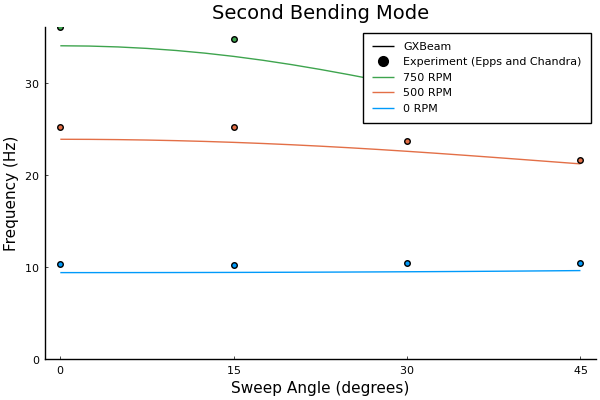

In [11]:
ph[2]

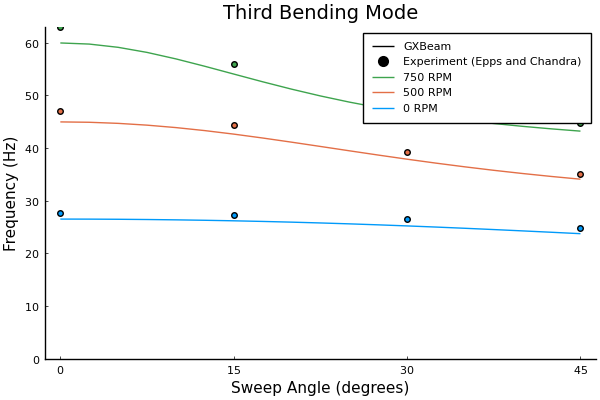

In [12]:
ph[3]

In [13]:
names = ["1T/5B", "5B/1T", "4B/1T"]
indices = [5, 7, 6]

experiment_frequencies = [
    95.4 87.5 83.7 78.8;
    106.6 120.1 122.6 117.7;
    132.7 147.3 166.2 162.0
]

plot(
    title = "Coupled Torsion-Bending Modes at 750 RPM",
    xticks = 0:15:45,
    xlabel = "Sweep Angle (degrees)",
    ylim = (0, Inf),
    ylabel = "Frequency (Hz)",
    legend = :bottomleft,
    grid = false,
    overwrite_figure=false
    )

plot!([], [], color=:black, label="GXBeam")
scatter!([], [], color=:black,
    label="Experiment (Epps and Chandra)")

for k = 1:length(indices)
    plot!(sweep*180/pi, frequency[indices[k]][:,end], label=names[k], color=k)
    scatter!(experiment_sweep, experiment_frequencies[k,:], label="", color=k)
end

As you can see, the frequency results from the eigenmode analysis in this package
compare well with experimental results.

We can also visualize eigenmodes using ParaView.  Here we will visualize the first
bending mode for the 45 degree swept tip at a rotational speed of 750 RPM.  This can be
helpful for identifying different eigenmodes.

In [14]:
# write the response to vtk files for visualization using ParaView
write_vtk("rotating-eigenmode", assembly, state[end,end],
    λ[end,end][1], eigenstates[end,end][1]; mode_scaling = 100.0)

![](../assets/rotating-eigenmode.gif)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*